#### This strategy is based on a simple long/short trend-following rule, that aims at exploiting increasing pressure on both sides. It first identifies those assets with the highest Hurst exponent in order to be confident of the "trending" nature of the time series. Once selected the assets, it calculates moving averages to define the trend and the COT index to confirm the sentiment for that asset over a 12-week period. Whenever there is a breakout, we buy or sell the asset accordingly. The stop loss is set as x-times the pullback from a recent top/bottom. It also weighs assets according to their volatility.

# Import libraries

In [29]:
#Import libraries
import pandas as pd
import numpy as np
import yfinance as yf
import quandl
import pyfolio as pf
from hurst import compute_Hc

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-darkgrid')

import warnings
warnings.filterwarnings('ignore')

# Set time windows

In [30]:
#Period for data download
start_date="2006-12-31"
end_date="2021-07-01"

#Period for Hurst exponent calculus
He_start = '2007-06-30'
He_end = '2014-06-30'

#Period for backtest
bt_start = '2014-06-30'
bt_end = '2021-06-30'

# Dowload data

In [31]:
#Download price data for each asset from Yahoo! Finance --> for some assets data start from 12/2003
ticker_list_fut = ['YM=F', 'ES=F', 'NQ=F', 'ZT=F', 'ZF=F', 'ZN=F', 'GC=F', 'SI=F', 'HG=F', 'LE=F', 'GF=F', 'HE=F', 'CL=F', 'NG=F', 'ZC=F', 'KE=F', 'ZS=F', 'CC=F', 'KC=F', 'CT=F', 'LBS=F', 'SB=F', 'EURUSD=X', 'JPYUSD=X', 'GBPUSD=X', 'CHFUSD=X', 'AUDUSD=X', 'CADUSD=X']

price_df = yf.download(ticker_list_fut, start=start_date, end=end_date)['Adj Close']
price_df.index = pd.to_datetime(price_df.index)
price_df.tail()

[*********************100%***********************]  28 of 28 completed


,AUDUSD=X,CADUSD=X,CC=F,CHFUSD=X,CL=F,CT=F,ES=F,EURUSD=X,GBPUSD=X,GC=F,...,NG=F,NQ=F,SB=F,SI=F,YM=F,ZC=F,ZF=F,ZN=F,ZS=F,ZT=F
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-24,0.757444,0.812790,2315.0,1.089194,73.300003,86.029999,4256.00,1.193317,1.396746,1775.599976,...,3.418,14354.25,16.930000,26.047001,34082.0,653.25,123.828125,132.171875,1371.25,110.253906
2021-06-25,0.758208,0.811537,2351.0,1.089170,74.050003,86.430000,4271.25,1.193033,1.391692,1776.599976,...,3.496,14339.00,16.900000,26.082001,34333.0,636.50,123.742188,131.859375,1329.75,110.250000
2021-06-28,0.759500,0.813544,2351.0,1.090881,72.910004,86.660004,4280.50,1.194215,1.389506,1779.599976,...,3.617,14512.50,17.230000,26.218000,34164.0,675.50,123.882812,132.265625,1357.00,110.281250
2021-06-29,0.756840,0.810767,2361.0,1.087417,72.980003,86.489998,4282.00,1.192890,1.387906,1762.800049,...,3.630,14563.00,17.230000,25.872000,34170.0,694.50,123.906250,132.265625,1359.75,110.285156
2021-06-30,0.751360,0.806699,NaN,1.085894,73.470001,84.029999,4288.50,1.190193,1.384275,1770.800049,...,3.650,14549.00,17.629999,26.165001,34399.0,720.00,123.960938,132.500000,1450.00,110.292969


In [32]:
#Rename columns
price_df.rename(columns={'YM=F':'dow', 'ES=F':'spx', 'NQ=F':'ndx', 'ZT=F':'us_2y', 'ZF=F':'us_5y', 'ZN=F':'us_10y', 'GC=F':'gold', 'SI=F':'silver', 'HG=F':'copper', 'LE=F':'live_cattle', 'GF=F':'feeder_cattle', 'HE=F':'lean_hogs','CL=F':'oil', 'NG=F':'nat_gas', 'ZC=F':'corn', 'KE=F':'wheat', 'ZS=F':'soybean', 'CC=F':'cocoa', 'KC=F':'coffee', 'CT=F':'cotton', 'LBS=F':'lumber', 'SB=F':'sugar', 'EURUSD=X':'eur', 'JPYUSD=X':'jpy', 'GBPUSD=X':'gbp', 'CHFUSD=X':'chf', 'AUDUSD=X':'aud', 'CADUSD=X':'cad'}, inplace=True)
price_df.tail()

,aud,cad,cocoa,chf,oil,cotton,spx,eur,gbp,gold,...,nat_gas,ndx,sugar,silver,dow,corn,us_5y,us_10y,soybean,us_2y
Date,,,,,,,,,,,,,,,,,,,,,
2021-06-24,0.757444,0.812790,2315.0,1.089194,73.300003,86.029999,4256.00,1.193317,1.396746,1775.599976,...,3.418,14354.25,16.930000,26.047001,34082.0,653.25,123.828125,132.171875,1371.25,110.253906
2021-06-25,0.758208,0.811537,2351.0,1.089170,74.050003,86.430000,4271.25,1.193033,1.391692,1776.599976,...,3.496,14339.00,16.900000,26.082001,34333.0,636.50,123.742188,131.859375,1329.75,110.250000
2021-06-28,0.759500,0.813544,2351.0,1.090881,72.910004,86.660004,4280.50,1.194215,1.389506,1779.599976,...,3.617,14512.50,17.230000,26.218000,34164.0,675.50,123.882812,132.265625,1357.00,110.281250
2021-06-29,0.756840,0.810767,2361.0,1.087417,72.980003,86.489998,4282.00,1.192890,1.387906,1762.800049,...,3.630,14563.00,17.230000,25.872000,34170.0,694.50,123.906250,132.265625,1359.75,110.285156
2021-06-30,0.751360,0.806699,NaN,1.085894,73.470001,84.029999,4288.50,1.190193,1.384275,1770.800049,...,3.650,14549.00,17.629999,26.165001,34399.0,720.00,123.960938,132.500000,1450.00,110.292969


In [33]:
#Fill missing values with prior ones
price_df_ffill = price_df.fillna(method='ffill')

In [34]:
#Slice data for Hurst exponent
price_data_He = price_df_ffill.loc[He_start:He_end]

#Slice DataFrame for backtest
price_data = price_df_ffill.loc[bt_start:bt_end]

# Calculate Hurst exponent

In [35]:
def get_hurst(series):
    # Calculate Hurst exponent
    hurst_value = compute_Hc(series, kind='price')[0]
    return hurst_value


def hurst_plot(hurst_plot_graph, title_name):
    plt.subplots(figsize=(10, 7))

    # Plot hurst exponent
    hurst_plot_graph = ['grey' if (x < 0.65) else 'green' for x in hurst.values]
    seaborn.barplot(x=hurst.index, y=hurst.values, palette=hurst_plot_graph)

    # Set style for the bar graph
    plt.axhline(0.65, color="red")
    plt.title(title_name, fontsize=14)
    plt.ylabel('Hurst Values', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

In [36]:
commodities = ['gold', 'silver', 'copper', 'live_cattle', 'feeder_cattle', 'lean_hogs', 'oil', 'nat_gas', 'wheat', 'corn', 'soybean', 'cocoa', 'coffee', 'cotton', 'lumber', 'sugar']

currencies = ['eur', 'jpy', 'gbp', 'chf', 'aud', 'cad']

stock_indices = ['dow', 'spx', 'ndx']

treasuries = ['us_2y', 'us_5y', 'us_10y']



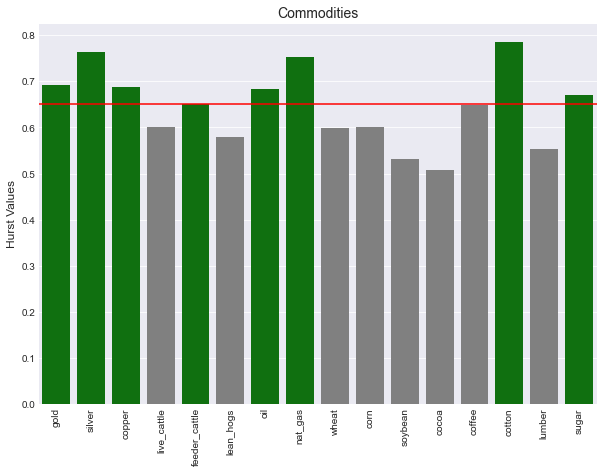

In [37]:
# Get Hurst exponenet of commodities
hurst = price_data_He[commodities].apply(get_hurst)

# Plot Hurst exponent values
hurst_plot(hurst.sort_values(0), 'Commodities')

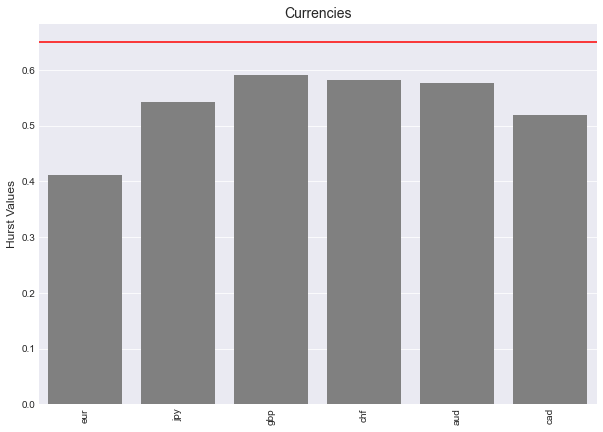

In [38]:
# Get Hurst exponenet of commodities
hurst = price_data_He[currencies].apply(get_hurst)

# Plot Hurst exponent values
hurst_plot(hurst.sort_values(0), 'Currencies')

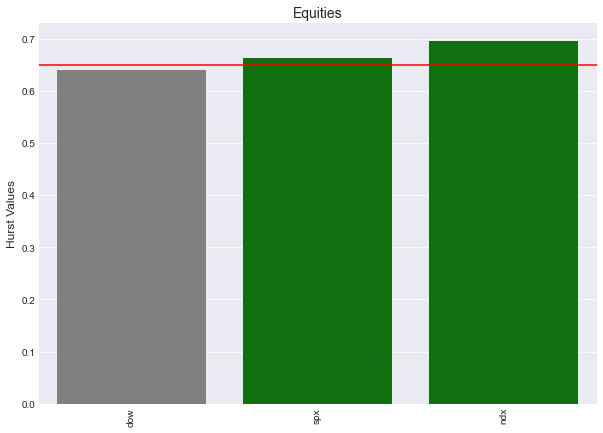

In [39]:
# Get Hurst exponenet of commodities
hurst = price_data_He[stock_indices].apply(get_hurst)

# Plot Hurst exponent values
hurst_plot(hurst.sort_values(0), 'Equities')

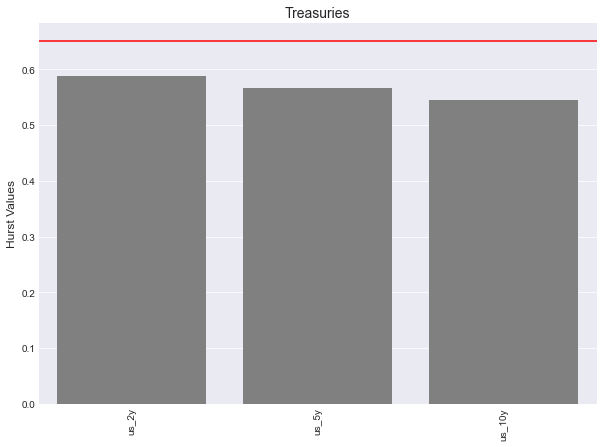

In [40]:
# Get Hurst exponenet of commodities
hurst = price_data_He[treasuries].apply(get_hurst)

# Plot Hurst exponent values
hurst_plot(hurst.sort_values(0), 'Treasuries')

In [41]:
data = price_data_He[:]

# Calculate Hurst exponent of all securities
hurst = data.apply(get_hurst)

# Store Hurst exponent in a dataframe
hurst = pd.DataFrame(hurst, columns=['hurst_exponent'])

# Keep only those securities having Hurst value greater than 0.65
filtered_hurst = hurst.loc[hurst['hurst_exponent'] > 0.65].sort_values(
    by='hurst_exponent', ascending=False)

print(filtered_hurst)

               hurst_exponent
cotton               0.785814
silver               0.763890
nat_gas              0.753096
ndx                  0.694499
gold                 0.691639
copper               0.686846
oil                  0.683357
sugar                0.670271
spx                  0.661755
feeder_cattle        0.651540


In [42]:
#We select only those assets with a Hurst exponent > 0.65 where there are data for the COT

# COT index

In [43]:
#List of assets for COT data (dow is left outside because lack of cot data from the beginning of the period)
#Stocks
spx = "CFTC/138741_FO_L_ALL" #since 1986
ndx = "CFTC/209742_FO_L_ALL" #since 1999

#Commodities
gold = "CFTC/088691_FO_L_ALL" #since 1995
silver = "CFTC/084691_FO_L_ALL" #since 1995
copper = "CFTC/085692_FO_L_ALL" #since 1995
feeder_cattle = 'CFTC/061641_FO_L_ALL' #since 1995
oil = "CFTC/067651_FO_L_ALL" #since 1995
nat_gas = "CFTC/023651_FO_L_ALL" #since 1995
cotton = "CFTC/033661_FO_L_ALL" #since 1995 

In [44]:
#Retrieveing data from Quandl
token="my_key"

#COT data
#Stocks
spx_cot = quandl.get([spx+"."+"2", spx+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)
ndx_cot = quandl.get([ndx+"."+"2", ndx+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)

#Commodities
gold_cot = quandl.get([gold+"."+"2", gold+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)
silver_cot = quandl.get([silver+"."+"2", silver+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)
copper_cot = quandl.get([copper+"."+"2", copper+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)
feeder_cattle_cot = quandl.get([feeder_cattle+"."+"2", feeder_cattle+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)
oil_cot = quandl.get([oil+"."+"2", oil+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)
nat_gas_cot = quandl.get([nat_gas+"."+"2", nat_gas+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)
cotton_cot = quandl.get([cotton+"."+"2", cotton+"."+"3"], start_date=start_date, end_date=end_date, authtoken=token)

In [45]:
#COT Index calculation function
def cot_index(window, data):
    
    #Rename columns
    data.columns = ['noncommercial_long', 'noncommercial_short']
    
    #Calculate net position
    data['noncommercial_net'] = data['noncommercial_long'] - data['noncommercial_short']
    
    #Calculate rolling max
    data['rol_max'] = data['noncommercial_net'].rolling(cot_window).max()
    
    #Calculate rollin min
    data['rol_min'] = data['noncommercial_net'].rolling(cot_window).min()
    
    #Calculate COT index
    data['cot_index'] = (data['noncommercial_net'] - data['rol_min']) / (data['rol_max'] - data['rol_min'])
    
    #Drop missing values
    data.dropna(inplace=True)
    
    #Multiply by 100
    
    data['cot_index'] = round(data['cot_index'].mul(100), 0)
    
    #Resample to daily
    data = (data.resample('b').ffill().reset_index())
    
    #Set Date as index
    data.set_index('Date', inplace=True)
    
    return data['cot_index']

In [46]:
#COT Index calculation for each asset
cot_window=12

#Stocks
spx_cot_index = cot_index(cot_window, spx_cot)
ndx_cot_index = cot_index(cot_window, ndx_cot)

#Commodities
gold_cot_index = cot_index(cot_window, gold_cot)
silver_cot_index = cot_index(cot_window, silver_cot)
copper_cot_index = cot_index(cot_window, copper_cot)
feeder_cattle_cot_index = cot_index(cot_window, feeder_cattle_cot)
oil_cot_index = cot_index(cot_window, oil_cot)
nat_gas_cot_index = cot_index(cot_window, nat_gas_cot)
cotton_cot_index = cot_index(cot_window, cotton_cot)

In [47]:
#Join COT index data for each asset in a single DataFrame
cot_index_df = pd.concat([spx_cot_index, ndx_cot_index, gold_cot_index, silver_cot_index, copper_cot_index, feeder_cattle_cot_index, oil_cot_index, nat_gas_cot_index, cotton_cot_index], axis=1)
cot_index_df.columns=['spx', 'ndx', 'gold', 'silver', 'copper', 'feeder_cattle', 'oil', 'nat_gas', 'cotton']
cot_index_df.head()

,spx,ndx,gold,silver,copper,feeder_cattle,oil,nat_gas,cotton
Date,,,,,,,,,
2007-03-20,100.0,19.0,47.0,0.0,100.0,100.0,94.0,0.0,85.0
2007-03-21,100.0,19.0,47.0,0.0,100.0,100.0,94.0,0.0,85.0
2007-03-22,100.0,19.0,47.0,0.0,100.0,100.0,94.0,0.0,85.0
2007-03-23,100.0,19.0,47.0,0.0,100.0,100.0,94.0,0.0,85.0
2007-03-26,100.0,19.0,47.0,0.0,100.0,100.0,94.0,0.0,85.0


In [48]:
#Slice COT index DataFrame for backtest period
cot_index_data = cot_index_df.loc[bt_start:bt_end]
cot_index_data.tail()

,spx,ndx,gold,silver,copper,feeder_cattle,oil,nat_gas,cotton
Date,,,,,,,,,
2021-06-23,0.0,69.0,0.0,25.0,0.0,80.0,100.0,5.0,25.0
2021-06-24,0.0,69.0,0.0,25.0,0.0,80.0,100.0,5.0,25.0
2021-06-25,0.0,69.0,0.0,25.0,0.0,80.0,100.0,5.0,25.0
2021-06-28,0.0,69.0,0.0,25.0,0.0,80.0,100.0,5.0,25.0
2021-06-29,5.0,92.0,0.0,25.0,6.0,94.0,100.0,11.0,56.0


# Strategy

In [49]:
#Define the strategy_parameters dictionary
strategy_parameters = {}
# Define slow and fast windows 
strategy_parameters["slow_ma"] = 80
strategy_parameters["fast_ma"] = 40
# High window
strategy_parameters["high_low_window"] = 20
# Volatilty window
strategy_parameters["volatility_window"] = 40
# Breakout window
strategy_parameters["breakout_window"] = 50
#COT window
strategy_parameters["COT_index_threshold_long"] = 30
strategy_parameters["COT_index_threshold_short"] = 70
#Pullback level
strategy_parameters["pullback_level_long"] = -5
strategy_parameters["pullback_level_short"] = 5

In [50]:
#Strategy formula
def trend_following_COT(strategy_parameters, ticker, price_data):
    # Calculate the exponential moving average using 80 and 40-day windows
    price_data['fast_ma'] = price_data[ticker].ewm(span=strategy_parameters["fast_ma"]).mean()
    price_data['slow_ma'] = price_data[ticker].ewm(span=strategy_parameters["slow_ma"]).mean()

    # Define the trend
    price_data['trend'] = price_data['fast_ma'] > price_data['slow_ma']

    # Calculate the daily price volatility
    price_data['volatility'] = price_data[ticker].diff().rolling(strategy_parameters["volatility_window"]).std()

    # Calculate the long position
    # Keep track of recent high
    price_data['highest'] = price_data[ticker].rolling(strategy_parameters["high_low_window"]).max()

    # Calculate the indicator when there is uptrend
    price_data['pullback'] = np.nan
    price_data.loc[price_data.trend, 'pullback'] = \
        (price_data[ticker] - price_data.highest) / price_data.volatility

    # Calculate the rolling max for the breakout line when there is an uptrend
    price_data.loc[price_data.trend, 'breakout'] = \
        price_data[ticker].rolling(strategy_parameters["breakout_window"]).max()

    # Initialise the long position to NaN
    price_data['long_position'] = np.nan

    # Define the rule for buying and holding a long position
    # The asset is in an uptrend, there is a breakout and COT index is greater than 30
    price_data['long_entry'] = \
        (price_data[ticker] >= price_data['breakout']) & price_data['trend'] & (cot_index_data[ticker] > strategy_parameters["COT_index_threshold_long"]) 

    # Define the rule for exiting a long position
    # The pullback is lesser than 5 units
    price_data['long_exit'] = price_data['pullback'] < strategy_parameters["pullback_level_long"]

    # Set the long_position to 1 for holding long position, and 0 for long exit
    price_data.loc[price_data['long_entry'], 'long_position'] = 1
    price_data.loc[price_data['long_exit'], 'long_position'] = 0
    
    # Get the long position
    price_data['long_position'] = price_data['long_position'].ffill().fillna(0)
    
    # Calculate the short position
    # Keep track of recent low
    price_data['lowest'] = \
        price_data[ticker].rolling(strategy_parameters["high_low_window"]).min()

    # Calculate the indicator when there is downtrend
    price_data.loc[~price_data.trend, 'pullback'] = \
        (price_data[ticker] - price_data.lowest) / price_data.volatility

    # Calculate the rolling min for the breakout line when there is a downtrend
    price_data.loc[~price_data.trend, 'breakout'] = \
        price_data[ticker].rolling(strategy_parameters["breakout_window"]).min()

    # Initialise the short position to NaN
    price_data['short_position'] = np.nan

    # Define the rule for taking a short position
    # The asset is in a downtrend, there is a breakout and the COT index is below 70
    price_data['short_entry'] = \
        (price_data[ticker] <= price_data['breakout']) & (~price_data['trend']) & (cot_index_data[ticker] < strategy_parameters["COT_index_threshold_short"]) 

    # Define the rule for exiting a short position
    # The pullback is greater than 5 units 
    price_data['short_exit'] = price_data['pullback'] > strategy_parameters["pullback_level_short"]

    # Set the short_position to -1 for holding short position, and 0 for short exit
    price_data.loc[price_data['short_entry'], 'short_position'] = -1
    price_data.loc[price_data['short_exit'], 'short_position'] = 0
    
    # Get the short position
    price_data['short_position'] = price_data['short_position'].ffill().fillna(0)

    '''
    The following three lines of code are added to the previous code.
    The strategy returns is computed and returned as the output of the function.
    '''
    # Consider both long and short positions
    price_data['total_position'] = price_data.long_position + price_data.short_position

    # Calculate the strategy returns
    price_data['strategy_returns'] = price_data[ticker].pct_change() * price_data.total_position.shift(1)
    
    # Give the output as the strategy returns
    return price_data['strategy_returns']

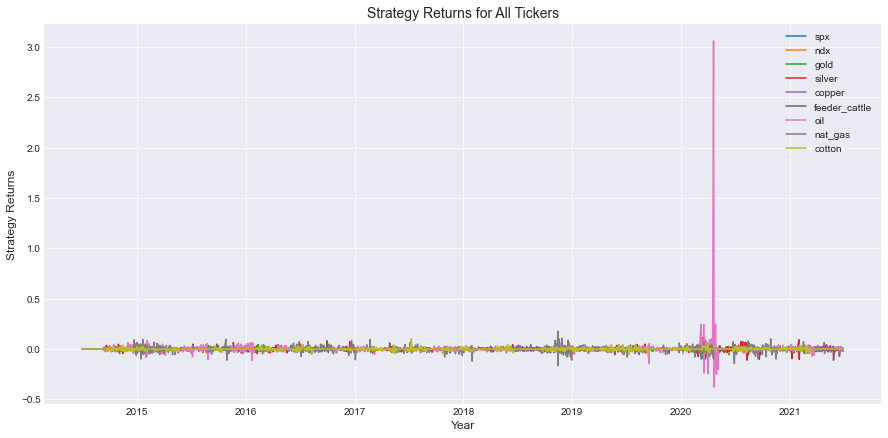

In [51]:
#List of tickers
tickers = ['spx', 'ndx', 'gold', 'silver', 'copper', 'feeder_cattle', 'oil', 'nat_gas', 'cotton']

# Define the DataFrame to store the strategy returns for each asset
strategy_returns = pd.DataFrame()

# Call the trend_following_strategy function to get the strategy returns
for asset in tickers:
    strategy_returns[asset] = \
        trend_following_COT(
                            strategy_parameters,
                            asset,
                            price_data
                            )
# Define the plot figure
plt.figure(figsize=(15, 7))

# Set the title and axis labels
plt.title('Strategy Returns for All Tickers', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Strategy Returns', fontsize=12)

# Plot the strategy returns
plt.plot(strategy_returns)

# Add the legend
plt.legend(tickers)

# Display the plot
plt.show()

# Volatility-based weight allocation

In [52]:
# Calculate the volatility of the tickers
volatility = price_data[tickers].pct_change().rolling(strategy_parameters["volatility_window"]).std()

# Calculate the inverse volatility
inverse_volatility = 1 / volatility

# Calculate the weights for each ticker
weights = inverse_volatility.div(inverse_volatility.sum(axis=1), axis=0)

# Print a sample of the weights
round(weights.tail(10), 3)

,spx,ndx,gold,silver,copper,feeder_cattle,oil,nat_gas,cotton
Date,,,,,,,,,
2021-06-17,0.218,0.141,0.147,0.084,0.071,0.073,0.096,0.083,0.088
2021-06-18,0.218,0.142,0.146,0.083,0.071,0.072,0.096,0.082,0.092
2021-06-21,0.216,0.143,0.145,0.083,0.072,0.072,0.093,0.083,0.092
2021-06-22,0.212,0.140,0.143,0.082,0.083,0.071,0.092,0.083,0.094
2021-06-23,0.211,0.140,0.143,0.082,0.088,0.070,0.092,0.082,0.091
2021-06-24,0.211,0.139,0.142,0.082,0.087,0.069,0.093,0.080,0.096
2021-06-25,0.212,0.139,0.141,0.081,0.087,0.069,0.095,0.079,0.097
2021-06-28,0.211,0.137,0.143,0.088,0.087,0.068,0.094,0.076,0.096
2021-06-29,0.211,0.142,0.141,0.087,0.086,0.068,0.094,0.075,0.096


# Volatility-weighted strategy returns

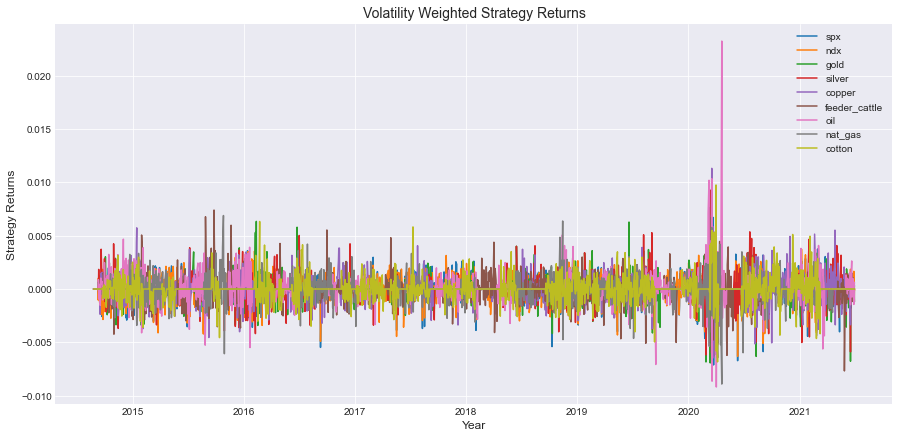

In [53]:
# Calculate the strategy returns of each ticker based on their weight
ticker_contribution = strategy_returns * weights

# Define the plot figure
plt.figure(figsize=(15, 7))

# Set the title and axis labels
plt.title('Volatility Weighted Strategy Returns', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Strategy Returns', fontsize=12)

# Plot the volatility weighted strategy returns
plt.plot(ticker_contribution)

# Add the legend
plt.legend(tickers)

# Display the plot
plt.show()

# Portfolio returns

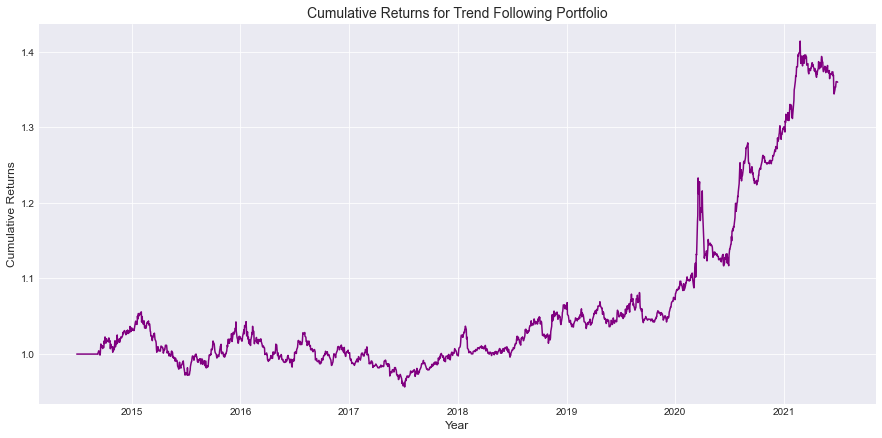

In [54]:
# Calculate the portfolio returns
portfolio_returns = ticker_contribution.sum(axis=1)

# Calculate the cumulative portfolio returns
cum_portfolio_returns = (portfolio_returns+1).cumprod()

# Define the plot figure
plt.figure(figsize=(15, 7))

# Set the title and axis labels
plt.title('Cumulative Returns for Trend Following Portfolio', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)

# Plot the cumulative returns
plt.plot(cum_portfolio_returns, color='purple')

# Display the plot
plt.show()

# Analyze the results

In [55]:
#Calculate benchmark returns
spx_rets = price_data['spx'].pct_change()
benchmark_rets = spx_rets
benchmark_rets.head()

Date
2014-06-30         NaN
2014-07-01    0.006786
2014-07-02    0.001017
2014-07-03    0.000000
2014-07-04    0.000000
Freq: B, Name: spx, dtype: float64

Start date,2014-06-30
End date,2021-06-30
Total months,87
,Backtest
Annual return,4.3%
Cumulative returns,36.0%
Annual volatility,6.5%
Sharpe ratio,0.68
Calmar ratio,0.46
Stability,0.55
Max drawdown,-9.4%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.43,2020-03-18,2020-06-12,2020-08-04,100
1,9.41,2015-02-02,2017-07-06,2018-11-20,992
2,4.95,2021-02-24,2021-06-18,NaT,NaN
3,4.34,2020-09-01,2020-10-01,2020-12-10,73
4,3.68,2019-09-03,2019-09-16,2020-01-06,90


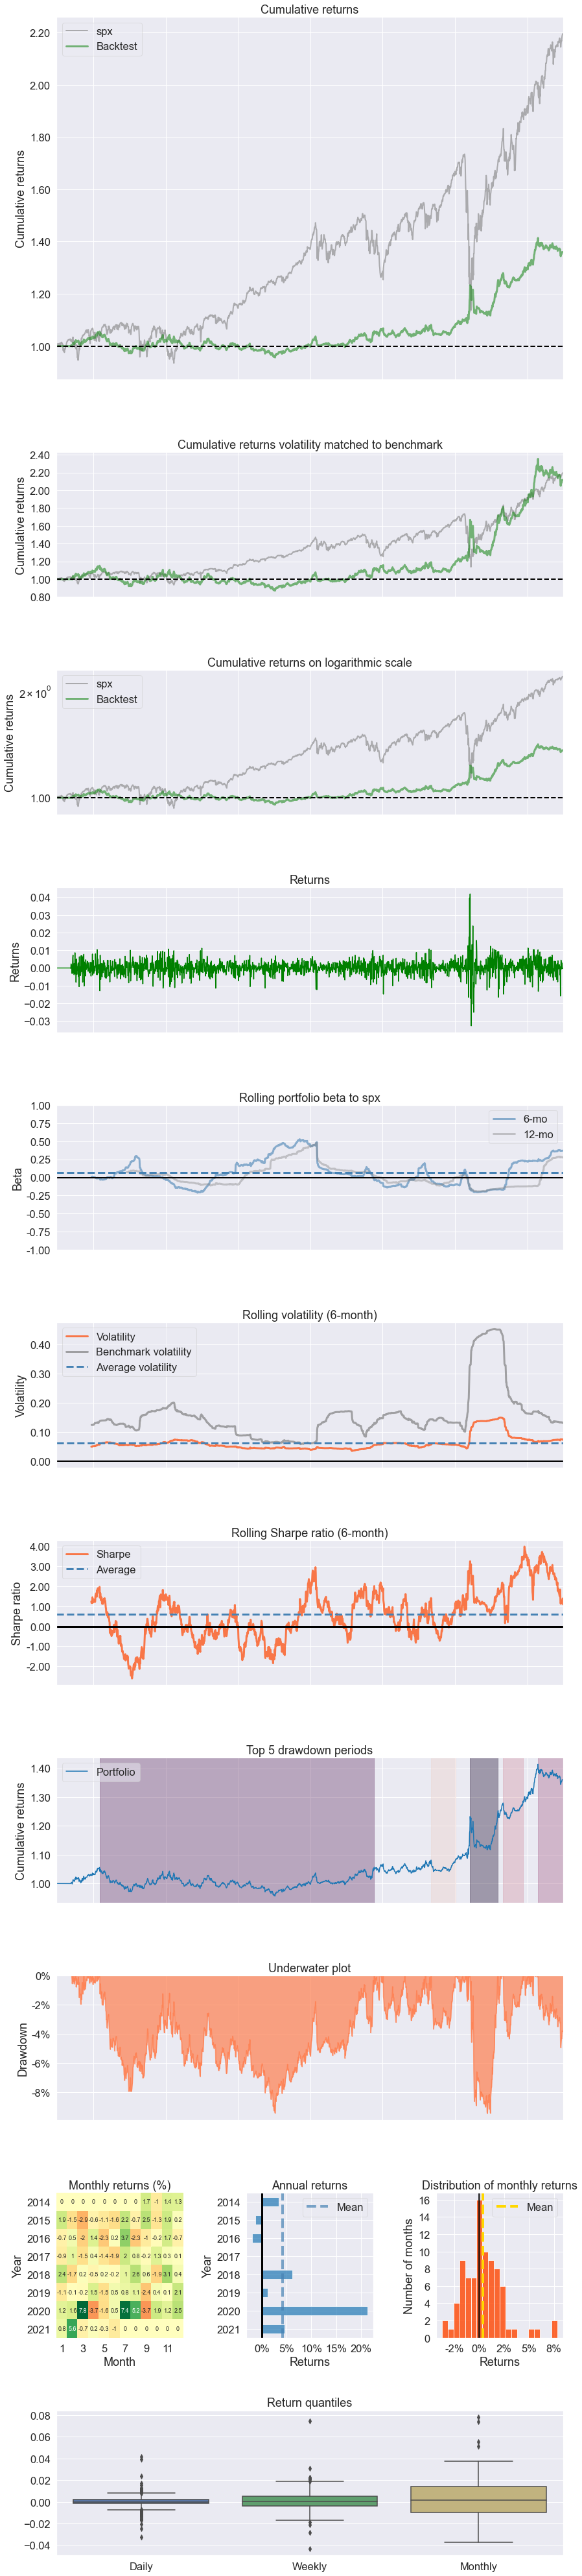

In [56]:
pf.create_returns_tear_sheet(portfolio_returns, benchmark_rets=benchmark_rets)

#### The strategy suffers in the first half of the backtest, but then it performs quite well (especially during volatility spikes). Maybe not the best strategy if considered on a standalone basis, but in a portfolio of well-diversified strategies it can prove to be a decent hedge during market turmoil. Parameters can be optimized, but the idea is to stay as long as possible in any trend and give each asset an equal chance to contribution of performances.